## Train an RL agent
This notebook will focus the following topics:

 - define reward function,
 - define featureize function,
 - training a single RL agent.

In this notebook a reinforcement learning agent is trained to control the current flowing through an inductor.
It will be shown for an easy case how the agent can learn and be applied to an electrical power grid simulated with de JEG package.

The use case is shown in the figure below.
This environment consists of a single phase electrical power grid with 1 source and 1 load connected via a cable.

![](figures/RL_single_agent.png "")

First the environment is defined in the configuration shown in the figure. 
For more information how to setup an environment see `Env_Create_DEMO.ipynb`.

`RL` is selected as `control_type` selected for the source (`parameters["source"][1]["control_type"]`).
Initially, any key can be used as the `mode`. Here, we choose the name `my_ddpg`. 
This is then required to select the corresponding defined/desired agent to control this source.
The key is used to link the corresponding state and action ids with the `my_ddpg` agent in the `Dare_Wrapper`.
Based on these indices, the state assigned to the agent is passed to it as input in the env and the appropriate actions are passed from the agent to the appropriate places in the env in the `MultiAgentGridController`.
For further details please refer to Userguide -> `MultiAgentGridController`.



In [1]:
using Dare
using ReinforcementLearning

In [2]:
# calculate passive load for wanted setting / power rating
R_load, L_load, X, Z = Parallel_Load_Impedance(100e3, 1, 230)

# define grid using CM
CM = [0. 1.
    -1. 0.]

# Set parameters accoring graphic above
parameters = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => 200e3, "control_type" => "RL", "mode" => "my_ddpg", "fltr" => "L"),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit"=>1e4, "i_limit"=>1e4),
                    ],
    "grid" => Dict{Any, Any}("phase" => 1)
)

Dict{Any, Any} with 3 entries:
  "source" => Any[Dict{Any, Any}("control_type"=>"RL", "mode"=>"my_ddpg", "fltr…
  "load"   => Any[Dict{Any, Any}("v_limit"=>10000.0, "i_limit"=>10000.0, "R"=>1…
  "grid"   => Dict{Any, Any}("phase"=>1)

To teach the agent that it should control the current it need on the one hand the information about which value the current shoud be (reference value) (->`featurize`) and how good the state is which was reached using the chosen action (-> `reward`).

Therefore, the reference value has to be defined. 
Here we will use a constant value to keep the example simple.
But since the the `reference(t)` function take the simulation time as argument, more complex, time dependent signals could be defined.

In [3]:
function reference(t)
    return 1
end

reference (generic function with 1 method)

Then the `featurize()` function is defined which has the tasks to add the reference value based on the control target which should be learned:
Here the signal generated by the `reference` function is added to the states given to the agent. This is neccessary for the agent to learn in this case that the reward is maximized if the measured current fits the reference value.
These reference value has to be normalized in an appropirate way that it fits to the range of the normalized states.

Additionally more signals could be added here to enhance the learning process.

Handing over the states which should be known to the agent is already implemented internally in the env.
The environment can constits of more states then should be known to te agent. Reasons can be like shown in this examples, that the agent is supplying a load which is ,e.g., 1 km away from the source the agent controls. 
In that case it is common that the agent has no knowlegde about states of the load since no communication and measurements exchange between the source and the load is assumed. 
Anonther example is that the electrical power grid consits of multiple sources and loads. The other sources are controlled by other agents or classic controllers. In that case, typically every controller / agent has knowlegde of the states of the source it controls but not about the states another agent/controller controls.
(For more information see `MultiAgentGridController` and `inner_featurize` of the `env`.)

The `featurize` function checks for the chosen key (here, `my_ddpg`) and appends the reference to the state which is provided to the `my_ddpg` agent:

In [4]:
featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end

#9 (generic function with 1 method)

Before defining the environment, the `reward()` function has to be defined to give a feedback to the agent how good the chose action was.
First, the state to be controlled is taken from the current environment states.
Since the states are normalized by the limits the electrical components can handle, a value greater then `1` means that the state limit is exceeded typically leading to a system crash.
Therefore, first it is checked if the measured state is greate then `1`. In that case a punishment is returned which , here, is chosen to `r = -1`.

In the case that the controlled state is within the valide state space, the reward is caculated based on the error between the wanted reference value and the measured state value. 
If these values are the same, meaning the agent perfectly fullfills the control task, a reward of `r = 1` is returned to the agent. ( -> r $\in$ [-1, 1]).
If the measured value differs from the reference, the error - based on the root-mean square error (RMSE) in this example - is substracted from the maximal reward: `r = 1 - RMSE`:

$r = 1 - \sqrt{\frac{|i_\mathrm{L,ref} - i_\mathrm{L1}|}{2}}$

To keep the reward in the wanted range, the current difference is devided by 2. (E.g., in worst case, if a reference value equal to the corresponding current limit is chosen $i_\mathrm{L,ref} = i_\mathrm{lim}$ and the measured current is the negative current limit $i_\mathrm{L1} = -i_\mathrm{lim}$ more the 1 would be substracted without this normaization).

In [5]:
function reward_function(env, name = nothing)
    if name == "my_ddpg"
        index_1 = findfirst(x -> x == "source1_i_L1", env.state_ids)
        state_to_control = env.state[index_1]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]          
            r = 1-((abs.(refs/norm_ref - state_to_control)/2).^0.5)
            return r 
        end
    end
end

reward_function (generic function with 2 methods)

Then, the defined parameters, featurize and reward functions are used to create an environment consisting of the electircal power grid. To keep the first learning example simple the action given to the env is internally not delayed. 

In [6]:
env = SimEnv(
    CM = CM, 
    parameters = parameters, 
    t_end = 0.1, 
    featurize = featurize_ddpg, 
    reward_function = reward_function, 
    action_delay = 0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



# SimEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{IntervalSets.ClosedInterval{Float64}}}(IntervalSets.ClosedInterval{Float64}[-1.0..1.0, -1.0..1.0, -1.0..1.0, -1.0..1.0])`

## Action Space

`Space{Vector{IntervalSets.ClosedInterval{Float64}}}(IntervalSets.ClosedInterval{Float64}[-1.0..1.0])`

## Current State

```
[0.0, 0.0, 0.0, 0.0]
```


In this example a `Deep Deterministic Policy Gradient` agent (https://arxiv.org/abs/1509.02971, https://spinningup.openai.com/en/latest/algorithms/ddpg.html) is chosen which can learn a control task on continous state and action space.
It is configured using the `create_agent_ddpg()` function which uses the information about the state and action ids, based on the parameter dict, stored in the `agent_dict` in the env:

`env.agent_dict[chosen_key]` (chosen key, here, `my_ddpg`):
- `"source_number"`: ID/number of the source the agent with this key controls
- `"mode"`: Name of the agent
- `"action_ids"`: List of strings with the action ids the agent controls/belong to the "source_number"`
- `"state_ids"`: List of strings with the state ids the agent controls/belong to the "source_number"`

These information are used in the `setup_agents()` methode to configure the experiment.

The agent is configured to receive as many inputs as it is given states by the environment and return as many outputs as actions requested from the env corresponding to the ids.

In [7]:
agent = create_agent_ddpg(na = length(env.agent_dict["my_ddpg"]["action_ids"]),
                          ns = length(state(env, "my_ddpg")),
                          use_gpu = false)

typename(Agent)
├─ policy => typename(DareDDPGPolicy)
│  ├─ behavior_actor => typename(DareNeuralNetworkApproximator)
│  │  ├─ model => typename(Flux.Chain)
│  │  │  └─ layers
│  │  │     ├─ 1
│  │  │     │  └─ typename(Flux.Dense)
│  │  │     │     ├─ weight => 20×3 Matrix{Float32}
│  │  │     │     ├─ bias => 20-element Vector{Float32}
│  │  │     │     └─ σ => typename(typeof(NNlib.relu))
│  │  │     ├─ 2
│  │  │     │  └─ typename(Flux.Dense)
│  │  │     │     ├─ weight => 10×20 Matrix{Float32}
│  │  │     │     ├─ bias => 10-element Vector{Float32}
│  │  │     │     └─ σ => typename(typeof(NNlib.relu))
│  │  │     └─ 3
│  │  │        └─ typename(Flux.Dense)
│  │  │           ├─ weight => 1×10 Matrix{Float32}
│  │  │           ├─ bias => 1-element Vector{Float32}
│  │  │           └─ σ => typename(typeof(tanh))
│  │  └─ optimizer => typename(Flux.Optimise.Adam)
│  │     ├─ eta => 0.001
│  │     ├─ beta
│  │     │  ├─ 1
│  │     │  │  └─ 0.9
│  │     │  └─ 2
│  │     │     └─ 0.999


The `setup_agents()` function takes the control types defined in the parameter dict and hands the correct indices to the corrensponding controllers / agents the experiment is configured.
The function returns `controllers` which is an instance of the dare package a `MultiAgentGridController` which contains the different agents and classic controllers and maps their actions to the corresponding sources is defined and returned. 

Since in this example only one RL agent will be used it only contains the defined `my_ddpg` agent. 
Therefore, the agent handed over to the `setup_agents()` function is extended by a name to a `named policy` (https://juliareinforcementlearning.org/docs/rlcore/#ReinforcementLearningCore.NamedPolicy )
Using this name the `MultiAgentGridController` (compare, https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.MADDPGManager) enables to call the different agents/controllers via name during training and application.

To use the pre defined agent, a dict linking tha `chosen_key`: `my_ddpg` to the defined RL agent is handed over to the `setup_agents` methode: 

In [8]:
my_custom_agents = Dict("my_ddpg" => agent)

controllers = setup_agents(env, my_custom_agents)

typename(MultiAgentGridController)
├─ agents => typename(Dict)
├─ action_ids => 1-element Vector{Any}
└─ hook => typename(data_hook)
   ├─ save_data_to_hd => false
   ├─ dir => "episode_data/"
   ├─ A => typename(Nothing)
   ├─ B => typename(Nothing)
   ├─ collect_state_paras => typename(Nothing)
   ├─ extra_state_paras => 0-element Vector{Any}
   ├─ extra_state_ids => 0-element Vector{Any}
   ├─ extra_state_names => 0-element Vector{Any}
   ├─ collect_sources => 0-element Vector{Any}
   ├─ collect_cables => 0-element Vector{Any}
   ├─ collect_loads => 0-element Vector{Any}
   ├─ collect_state_ids => 0-element Vector{Any}
   ├─ collect_next_state_ids => 0-element Vector{Any}
   ├─ collect_action_ids => 0-element Vector{Any}
   ├─ df => typename(DataFrames.DataFrame)
   │  ├─ columns => 0-element Vector{AbstractVector}
   │  └─ colindex => typename(DataFrames.Index)
   │     ├─ lookup => typename(Dict)
   │     └─ names => 0-element Vector{Symbol}
   ├─ tmp => typename(DataFrames.DataFr

The `controllers` in this examples consits only of the one RL agent (`my_ddpg`) and can be trained usin the `learn()` function to train 20 episodes:

In [9]:
learn(controllers, env, num_episodes = 20)

Progress:  10%|████▏                                    |  ETA: 0:06:43

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:25

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
         825.752 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│ my_ddpg
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│        
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸│        
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸│        
                 │⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇│        
                 │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇│        
                 │⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇│        
   Score         │⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀│        
                 │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀│        
                 │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀│        
                 │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

data_hook(false, "episode_data/", [-199.99999999999997 -2927.9783900064085 0.0 0.0; 5000.0 0.0 -5000.0 0.0; 0.0 4000.0 -832.0 -4000.0; 0.0 0.0 5000.0 -3150.5986137366094], [2927.9783900064085; 0.0; 0.0; 0.0;;], Any[0.0003415325753131024, 0.0002, 0.00025, 0.0002], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], 20020×5 DataFrame
   Row │ episode  time     action                             reward   done  
       │ Int64    Float32  Array…                             Nothing  Bool  
───────┼─────────────────────────────────────────────────────────────────────
     1 │       1   0.0     Union{Nothing, Float64}[0.025313…           false
     2 │       1   0.0001  Union{Nothing, Float64}[0.010598…           false
     3 │       1   0.0002  Union{Nothing, Float64}[0.017461…           false
     4 │       1   0.0003  Union{Nothing, Float64}[-0.04837…           false
     5 │       1   0.0004  Union{Nothing, Float64}[0.051734…           false
     6 │       1   0.0005  Union{Not

After the training, the `simulate()` function is used to run a test epiode without action noise and the state to be controlled ($i_\mathrm{L1}$) is plotted:

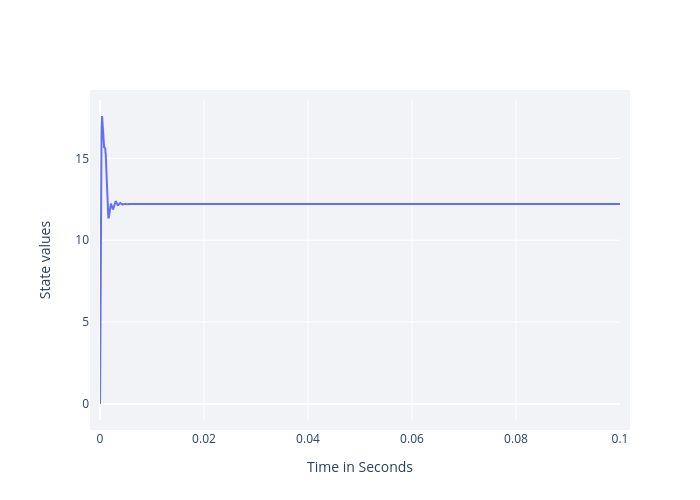

In [10]:

states_to_plot = ["source1_i_L1"]
hook = data_hook(collect_state_ids = states_to_plot)

simulate(controllers, env, hook=hook)

plot_hook_results(hook = hook,
                  states_to_plot  = states_to_plot)